## **Import Library**

In [1]:
import os
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image


## **Data Loading**

In [2]:
# Install gdown (jika belum tersedia)
!pip install gdown

# Gantilah file_id berikut dengan ID dari file ZIP kamu
file_id = "1HYo7tF6hkZYm6s8PzCUKHwGue8zJPl9g"

# Unduh file ZIP
!gdown --id $file_id --output Dataset.zip

with zipfile.ZipFile("Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Dataset")

# Cek isi folder
print(os.listdir("Dataset"))


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HYo7tF6hkZYm6s8PzCUKHwGue8zJPl9g
From (redirected): https://drive.google.com/uc?id=1HYo7tF6hkZYm6s8PzCUKHwGue8zJPl9g&confirm=t&uuid=84eeeed9-6f96-4060-b49f-575e1b77c245
To: /content/Dataset.zip
100% 861M/861M [00:09<00:00, 93.3MB/s]
['Dataset']


## **Data Preparation dan Preprocessing**

In [3]:
# Cek isi folder dataset
base_dir = "Dataset/Dataset"
categories = os.listdir(base_dir)
print("Label kategori:", categories)

Label kategori: ['plastic_bottle', 'can', 'other', 'glass_bottle']


In [4]:
# melihat jumlah data gambar
# Tentukan direktori dasar dataset
base_dir = "Dataset/Dataset"

# Dapatkan daftar semua kategori
categories = os.listdir(base_dir)

# Inisialisasi total jumlah gambar
total_images = 0

# Hitung jumlah gambar untuk setiap kategori dan total keseluruhan
for category in categories:
    category_dir = os.path.join(base_dir, category)
    # Hitung jumlah file dengan ekstensi .jpg di dalam direktori kategori
    num_images = len([f for f in os.listdir(category_dir) if f.endswith(".jpg")])
    print(f"Jumlah gambar di kategori '{category}': {num_images}")
    total_images += num_images

# Cetak total jumlah gambar keseluruhan
print(f"\nTotal keseluruhan gambar: {total_images}")

Jumlah gambar di kategori 'plastic_bottle': 1508
Jumlah gambar di kategori 'can': 1060
Jumlah gambar di kategori 'other': 1226
Jumlah gambar di kategori 'glass_bottle': 561

Total keseluruhan gambar: 4355


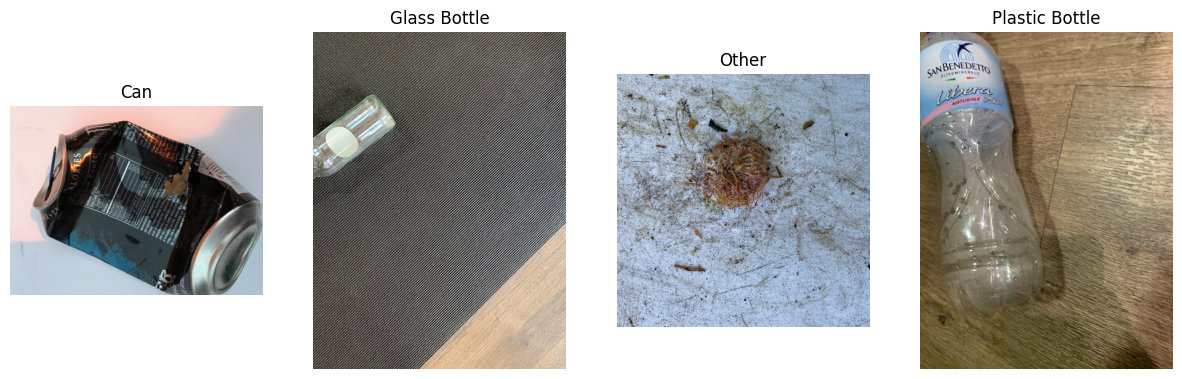

In [5]:
# Melihat gambar acak
# Tentukan path ke setiap folder kategori
can_dir = os.path.join(base_dir, 'can')
glass_bottle_dir = os.path.join(base_dir, 'glass_bottle')
other_dir = os.path.join(base_dir, 'other')
plastic_bottle_dir = os.path.join(base_dir, 'plastic_bottle')

# Dapatkan daftar semua gambar dalam setiap folder
can_images = os.listdir(can_dir)
glass_bottle_images = os.listdir(glass_bottle_dir)
other_images = os.listdir(other_dir)
plastic_bottle_images = os.listdir(plastic_bottle_dir)

# Pilih gambar acak dari setiap kategori
random_can_img = random.choice(can_images)
random_glass_bottle_img = random.choice(glass_bottle_images)
random_other_img = random.choice(other_images)
random_plastic_bottle_img = random.choice(plastic_bottle_images)

# Tentukan path lengkap ke gambar acak
random_can_img_path = os.path.join(can_dir, random_can_img)
random_glass_bottle_img_path = os.path.join(glass_bottle_dir, random_glass_bottle_img)
random_other_img_path = os.path.join(other_dir, random_other_img)
random_plastic_bottle_img_path = os.path.join(plastic_bottle_dir, random_plastic_bottle_img)

# Tampilkan gambar acak
img_can = mpimg.imread(random_can_img_path)
img_glass_bottle = mpimg.imread(random_glass_bottle_img_path)
img_other = mpimg.imread(random_other_img_path)
img_plastic_bottle = mpimg.imread(random_plastic_bottle_img_path)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_can)
plt.title("Can")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(img_glass_bottle)
plt.title("Glass Bottle")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img_other)
plt.title("Other")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(img_plastic_bottle)
plt.title("Plastic Bottle")
plt.axis("off")

plt.show()

### Split data

In [6]:
# split data training, testing, dan validasi (80:10:10)
base_dir = "Dataset/Dataset"
output_base = "split_dataset"
classes = os.listdir(base_dir)

for split in ['train', 'val', 'test']:
    for class_name in classes:
        os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    train_files, testval_files = train_test_split(images, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

    for split_name, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for fname in split_files:
            src = os.path.join(class_path, fname)
            dst = os.path.join(output_base, split_name, class_name, fname)
            shutil.copy(src, dst)

In [7]:
# Augmentasi pada data training
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
test_dir = os.path.join(output_base, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 3482 images belonging to 4 classes.
Found 436 images belonging to 4 classes.
Found 437 images belonging to 4 classes.


## **Modelling**

In [8]:
# melakukan modelling dengan MobilenetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Callback
checkpoint = ModelCheckpoint("mobilenetv2_trashure.keras", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 641ms/step - accuracy: 0.6058 - loss: 0.9521 - val_accuracy: 0.9037 - val_loss: 0.3144
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 57s 523ms/step - accuracy: 0.9228 - loss: 0.2732 - val_accuracy: 0.9610 - val_loss: 0.1930
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 59s 542ms/step - accuracy: 0.9488 - loss: 0.1825 - val_accuracy: 0.9495 - val_loss: 0.1516
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 558ms/step - accuracy: 0.9597 - loss: 0.1377 - val_accuracy: 0.9748 - val_loss: 0.1201
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 557ms/step - accuracy: 0.9659 - loss: 0.1147 - val_accuracy: 0.9748 - val_loss: 0.1013
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 549ms/step - accuracy: 0.9768 - loss: 0.0917 - val_accuracy: 0.9817 - val_loss: 0.0957
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 533ms/step - accuracy: 0.9757 - loss: 0.0812 - val_accuracy: 0.9839 - val_loss: 0.0793
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 546ms/step - accuracy: 0.9807 - loss: 0

## **Evaluasi**

In [11]:
# setelah training selesai, dan load model terbaik dari .keras
model = tf.keras.models.load_model('mobilenetv2_trashure.keras')
loss, acc = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.9606 - loss: 0.1315
Test Loss: 0.0852
Test Accuracy: 97.48%


In [12]:
# Mengambil riwayat akurasi train dari objek history
train_accuracy = history.history['accuracy']

# Menampilkan akurasi train
print(f"Train Accuracy: {train_accuracy[-1] * 100:.2f}%")

Train Accuracy: 99.45%


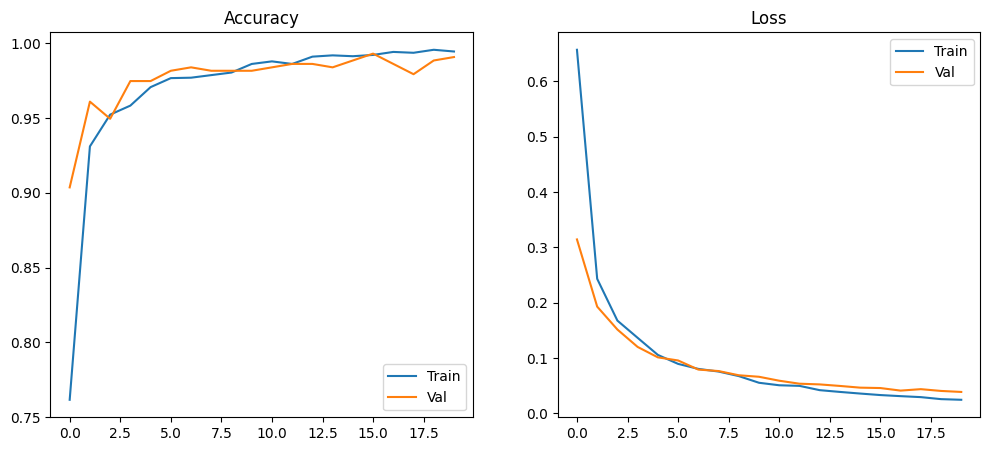

In [13]:
# membuat dan melihat plot akurasi dan loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.show()

## **Simpan Model dan interferensi**

In [14]:
# simpan dengan format savemodel
model.export("saved_model_trashure")

Saved artifact at 'saved_model_trashure'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137211650145936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211650144208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211650145744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211650141904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211650146128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211717426384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211717431760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211717427728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211717430224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137211717429072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13721171743

In [15]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_trashure")
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("mobilenetv2_trashure.tflite", "wb") as f:
    f.write(tflite_model)

In [16]:
# simpan dengan format tensorflowjs
!pip install tensorflowjs
# Konversi SavedModel ke format TFJS
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model \
    saved_model_trashure tfjs_model_trashure


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-28 04:22:35.255296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748406155.275430    8838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

In [17]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="mobilenetv2_trashure.tflite")
interpreter.allocate_tensors()

# Dapatkan input dan output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk preprocessing 1 gambar
def preprocess_tflite(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array

# Contoh inference
img_path = "/content/Dataset/Dataset/plastic_bottle/PET1,001.jpg"
input_data = preprocess_tflite(img_path)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Ambil label prediksi
predicted_class = np.argmax(output_data)
confidence = np.max(output_data)
print(f"Prediksi kelas: {predicted_class}, Confidence: {confidence:.2f}")

Prediksi kelas: 3, Confidence: 1.00


In [18]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="mobilenetv2_trashure.tflite")
interpreter.allocate_tensors()

# Dapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Mapping kelas (ganti sesuai urutan aslinya)
class_labels = ['can', 'glass bottle', 'plastic bottle', 'other']  # contoh, ganti sesuai labelmu

# Fungsi untuk prediksi dan tampilkan gambar
def predict_and_show(img_path):
    # Preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    # Inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Ambil prediksi
    pred_idx = np.argmax(output_data)
    confidence = np.max(output_data)
    label = f"{class_labels[pred_idx]} ({confidence*100:.2f}%)"

    # Visualisasi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}", fontsize=14)
    plt.show()


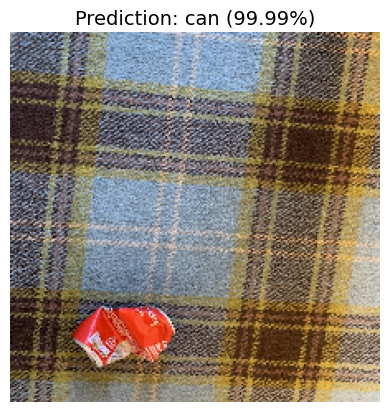

In [19]:
predict_and_show("/content/Dataset/Dataset/can/AluCan1,004.jpg")